In [2]:
import numpy as np
import pandas as pd
import time
import os
from functools import wraps

from dataclasses import dataclass

In [104]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.2f}".format)

# Common

In [8]:
def mean_absolute_percentage_error(y_true: list[float], y_pred: list[float]) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load Dataset

In [59]:
UNIQUE_ID = "unique_id"
SEPARATOR = "_"
file_name = "data.csv"
n = 2

In [60]:
df = pd.read_csv(file_name, delimiter=";")
df.head()

,Reporting Economy,Product/Sector,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,World,SI3_AGG - TO - Total merchandise,10510291.0,12131279.0,14031816.0,16168718.0,12564776.0,15301659.0,18337603.0,18508981.0,18958769.0,18999593.0,16554643.0,16036335.0,17741325.0,19550037.0,19017108.0,17653275.0,22365766.0,24925766.0
1,World,SI3_AGG - AG - Agricultural products,847715.0,942450.0,1131691.0,1342823.0,1177136.0,1354429.0,1649389.0,1655099.0,1731531.0,1746687.0,1565686.0,1585693.0,1731381.0,1810271.0,1788200.0,1809475.0,2148665.0,2325521.0
2,World,SI3_AGG - AGFO - Food,680936.0,753836.0,915653.0,1114698.0,998004.0,1115790.0,1350316.0,1369778.0,1445339.0,1480252.0,1332886.0,1357202.0,1473948.0,1533561.0,1533159.0,1573538.0,1836335.0,2007666.0
3,World,SI3_AGG - MI - Fuels and mining products,1810185.0,2319402.0,2674500.0,3554158.0,2299789.0,3074398.0,4122493.0,4164125.0,4051300.0,3720251.0,2380017.0,2033684.0,2611396.0,3264056.0,3102597.0,2326889.0,3670710.0,4950975.0
4,World,SI3_AGG - MIFU - Fuels,1457315.0,1801129.0,2047440.0,2884170.0,1838528.0,2395065.0,3268505.0,3399965.0,3309479.0,3026072.0,1808811.0,1492255.0,1948478.0,2528513.0,2370333.0,1571511.0,2555970.0,3865877.0


# Preprocessing

Since currently we are not handling the missing data, let's only take the columns with no null columns

In [61]:
def create_unique_id(df: pd.DataFrame, n: int) -> pd.DataFrame:
    columns = list(df.columns)
    columns = columns[:n]
    df[UNIQUE_ID] = df[columns].apply(
        lambda row: SEPARATOR.join(row.values.astype(str)), axis=1
    )
    cols = list(df.columns)
    cols.insert(0, cols.pop(cols.index(UNIQUE_ID)))
    df = df[cols]
    df = df.drop(columns=columns, axis=1)
    return df

In [62]:
df = create_unique_id(df, n)

In [63]:
def rename_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    df_grouped = df.groupby(UNIQUE_ID)
    df_grouped = df_grouped.filter(lambda x: len(x) > 1)

    unique_ids = df_grouped[UNIQUE_ID].unique()
    df = df.copy()
    for unique_id in unique_ids:
        rows = df_grouped[df_grouped[UNIQUE_ID] == unique_id]
        # TODO: This is hardcoded. We should find a way to sort the columns dynamically
        rows = rows.sort_values(by=["2005", "2006", "2007", "2022"], ascending=False)
        for i, row_index in enumerate(rows.index):
            if i == 0:
                df = df.drop(row_index)
            else:
                df.loc[row_index, UNIQUE_ID] = f"{unique_id}_{i+1}"
    return df

In [64]:
df = rename_duplicates(df)

In [65]:
df = df.set_index(UNIQUE_ID)
df = df.transpose()
df.head()

unique_id,World_SI3_AGG - TO - Total merchandise,World_SI3_AGG - AG - Agricultural products,World_SI3_AGG - AGFO - Food,World_SI3_AGG - MI - Fuels and mining products,World_SI3_AGG - MIFU - Fuels,World_SI3_AGG - MA - Manufactures,World_SI3_AGG - MAIS - Iron and steel,World_SI3_AGG - MACH - Chemicals,World_SI3_AGG - MACHPH - Pharmaceuticals,World_SI3_AGG - MAMT - Machinery and transport equipment,...,Zimbabwe_SI3_AGG - MACHPH - Pharmaceuticals,Zimbabwe_SI3_AGG - MAMT - Machinery and transport equipment,Zimbabwe_SI3_AGG - MAMTOF - Office and telecom equipment,Zimbabwe_SI3_AGG - MAMTOTEP - Electronic data processing and office equipment,Zimbabwe_SI3_AGG - MAMTOTTL - Telecommunications equipment,Zimbabwe_SI3_AGG - MAMTOTIC - Integrated circuits and electronic components,Zimbabwe_SI3_AGG - MAMTTE - Transport equipment,Zimbabwe_SI3_AGG - MAMTAU - Automotive products,Zimbabwe_SI3_AGG - MATE - Textiles,Zimbabwe_SI3_AGG - MACL - Clothing
2005,10510291.0,847715.0,680936.0,1810185.0,1457315.0,7302724.0,316470.0,1101752.0,275127.0,3855720.0,...,3.0,28.0,2.0,1.0,1.0,0.0,8.0,6.0,14.0,7.0
2006,12131279.0,942450.0,753836.0,2319402.0,1801129.0,8263994.0,375338.0,1244851.0,313193.0,4381947.0,...,3.0,228.0,11.0,10.0,1.0,0.0,165.0,16.0,23.0,17.0
2007,14031816.0,1131691.0,915653.0,2674500.0,2047440.0,9533196.0,479301.0,1478222.0,372901.0,4975712.0,...,2.0,206.0,11.0,3.0,7.0,0.0,84.0,28.0,67.0,18.0
2008,16168718.0,1342823.0,1114698.0,3554158.0,2884170.0,10475820.0,588219.0,1684177.0,420731.0,5363885.0,...,1.0,177.0,3.0,2.0,0.0,1.0,90.0,77.0,74.0,47.0
2009,12564776.0,1177136.0,998004.0,2299789.0,1838528.0,8379712.0,326017.0,1453993.0,438048.0,4219363.0,...,2.0,85.0,13.0,1.0,5.0,7.0,16.0,10.0,17.0,16.0


In [66]:
df = df.reset_index()
df = df.rename(columns={"index": "year"})
df.head()

unique_id,year,World_SI3_AGG - TO - Total merchandise,World_SI3_AGG - AG - Agricultural products,World_SI3_AGG - AGFO - Food,World_SI3_AGG - MI - Fuels and mining products,World_SI3_AGG - MIFU - Fuels,World_SI3_AGG - MA - Manufactures,World_SI3_AGG - MAIS - Iron and steel,World_SI3_AGG - MACH - Chemicals,World_SI3_AGG - MACHPH - Pharmaceuticals,...,Zimbabwe_SI3_AGG - MACHPH - Pharmaceuticals,Zimbabwe_SI3_AGG - MAMT - Machinery and transport equipment,Zimbabwe_SI3_AGG - MAMTOF - Office and telecom equipment,Zimbabwe_SI3_AGG - MAMTOTEP - Electronic data processing and office equipment,Zimbabwe_SI3_AGG - MAMTOTTL - Telecommunications equipment,Zimbabwe_SI3_AGG - MAMTOTIC - Integrated circuits and electronic components,Zimbabwe_SI3_AGG - MAMTTE - Transport equipment,Zimbabwe_SI3_AGG - MAMTAU - Automotive products,Zimbabwe_SI3_AGG - MATE - Textiles,Zimbabwe_SI3_AGG - MACL - Clothing
0,2005,10510291.0,847715.0,680936.0,1810185.0,1457315.0,7302724.0,316470.0,1101752.0,275127.0,...,3.0,28.0,2.0,1.0,1.0,0.0,8.0,6.0,14.0,7.0
1,2006,12131279.0,942450.0,753836.0,2319402.0,1801129.0,8263994.0,375338.0,1244851.0,313193.0,...,3.0,228.0,11.0,10.0,1.0,0.0,165.0,16.0,23.0,17.0
2,2007,14031816.0,1131691.0,915653.0,2674500.0,2047440.0,9533196.0,479301.0,1478222.0,372901.0,...,2.0,206.0,11.0,3.0,7.0,0.0,84.0,28.0,67.0,18.0
3,2008,16168718.0,1342823.0,1114698.0,3554158.0,2884170.0,10475820.0,588219.0,1684177.0,420731.0,...,1.0,177.0,3.0,2.0,0.0,1.0,90.0,77.0,74.0,47.0
4,2009,12564776.0,1177136.0,998004.0,2299789.0,1838528.0,8379712.0,326017.0,1453993.0,438048.0,...,2.0,85.0,13.0,1.0,5.0,7.0,16.0,10.0,17.0,16.0


In [23]:
until_year = 2019
size = df[pd.to_datetime(df["year"]).dt.year > until_year].shape[0]
test_ratio = size / df.shape[0]
print(f"Test ratio: {test_ratio}\n")

Test ratio: 0.16666666666666666



In [25]:
df = df.dropna(axis=1, how="any") # Drop columns with NaN values

In [ ]:
unique_ids = list(df.columns[1:])
unique_ids

In [67]:
data = df[["year", unique_ids[0]]]
data = data.rename(columns={unique_ids[0]: "rate"})
data.head()

unique_id,year,rate
0,2005,10510291.0
1,2006,12131279.0
2,2007,14031816.0
3,2008,16168718.0
4,2009,12564776.0


In [68]:
def process_single_series(single_series):
    data = single_series.copy()
    data.columns = ["date", "rate"]
    data["rate"] = data["rate"].astype(str)

    data["rate"] = data.rate.replace("ND", np.nan)

    data["date"] = pd.to_datetime(data["date"], format="%Y")
    data["rate"] = pd.to_numeric(data["rate"])

    # handling missing values (interpolation)
    data["rate"] = data["rate"].interpolate()

    data = data.resample("YS", on="date", label="left", closed="left").mean()

    # gradualize the data by linearly interpolating the data
    data = data.resample("D").asfreq()
    data = data.interpolate(method="linear")

    data["time"] = [i + 1 for i in range(len(data))]

    return data

In [69]:
data = process_single_series(data)
data.head()

,rate,time
date,,
2005-01-01,1.051029e+07,1
2005-01-02,1.051473e+07,2
2005-01-03,1.051917e+07,3
2005-01-04,1.052361e+07,4
2005-01-05,1.052806e+07,5


# Train Models

In [70]:
from dataclasses import dataclass

@dataclass
class ModelResult:
    model: object
    train_values: np.array
    test_values: np.array
    predictions: np.array
    mape: float

## Linear Regression

In [71]:
def train_test_split(data, test_ratio = 0.2):
    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    X_train = train.drop('rate',axis=1)
    X_test = test.drop('rate',axis=1)
    y_train = train[['rate']]
    y_test = test[['rate']]

    return X_train, X_test, y_train, y_test

In [37]:
from sklearn.linear_model import LinearRegression

def get_linear_regression_prediction(data : pd.DataFrame, test_ratio = 0.2) -> ModelResult:
    X_train, X_test, y_train, y_test = train_test_split(data, test_ratio)

    model = LinearRegression()
    model.fit(X = X_train, y = y_train)
    predictions = model.predict(X_test)

    predictions = predictions.reshape(-1)

    linear_reg_mape = mean_absolute_percentage_error(y_test.values.reshape(-1), predictions)

    return ModelResult(
        model,
        y_train.values.reshape(-1),
        y_test.values.reshape(-1),
        predictions,
        linear_reg_mape
    )

In [72]:
linear_reg_result = get_linear_regression_prediction(data)
print(f"Linear Regression MAPE: {linear_reg_result.mape}")

Linear Regression MAPE: 8.15924604964601


## ARIMA

In [73]:
from statsmodels.tsa.arima.model import ARIMA

In [74]:
def get_arima_prediction(data, test_ratio = 0.2, order = (3,1,2)) -> ModelResult:
    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    predictions = []

    arima = ARIMA(train.rate,order=order).fit()

    horizon = len(test)
    predictions.append(arima.forecast(horizon))
    predictions = np.array(predictions[0]).reshape((horizon,))

    predictions = predictions.reshape(-1)

    arima_mape = mean_absolute_percentage_error(test.rate, predictions)

    return ModelResult(
        arima,
        train.rate.values.reshape(-1),
        test.rate.values.reshape(-1),
        predictions,
        arima_mape
    )

In [75]:
arima_reg_result = get_arima_prediction(data)
print(f"ARIMA Regression MAPE: {arima_reg_result.mape}")

ARIMA Regression MAPE: 8.75717485615381


## Prophet

In [76]:
from prophet import Prophet

In [77]:
@dataclass
class ProphetModelResult(ModelResult):
    forecast: pd.DataFrame

In [80]:
def get_prophet_prediction(data, test_ratio = 0.2, interval_width=0.95) -> ProphetModelResult:
    data = data.reset_index()
    data = data.rename(columns={'date' : 'ds','rate' : 'y'})
    data = data[['ds', 'y']]

    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    my_model = Prophet(interval_width=interval_width)
    my_model.fit(train)

    future_dates = my_model.make_future_dataframe(periods=len(test), freq='D')

    forecast = my_model.predict(future_dates)

    predictions = forecast.yhat[train_size:].values.reshape(-1)

    prophet_mape = mean_absolute_percentage_error(test.y, predictions)

    return ProphetModelResult(
        my_model,
        train.y.values.reshape(-1),
        test.y.values.reshape(-1),
        predictions,
        prophet_mape,
        forecast
    )

In [81]:
prophet_reg_result = get_prophet_prediction(data)
print(f"Prophet Regression MAPE: {prophet_reg_result.mape}")

21:14:00 - cmdstanpy - INFO - Chain [1] start processing
21:14:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet Regression MAPE: 10.92641086860842


## LSTM

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [83]:
# the side effect of this is, that it actually removes look_back number of columns

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	# for i in range(len(dataset)-look_back-1):
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [84]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    return dataset, scaler

In [85]:
def split_lstm_train_test(data, test_ratio = 0.2, look_back=1):
    train_size = int(len(data) * (1 - test_ratio))
    train, test = data[0:train_size,:], data[train_size:len(data),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY

In [86]:
def get_trained_model(trainX, trainY, look_back, epochs=5):
    model = Sequential()

    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

    return model

In [87]:
def get_lstm_prediction(data, epochs=5, look_back = 1, test_ratio = 0.2) -> ModelResult:
    dataset = data.rate.values
    dataset = dataset.astype('float32').reshape(-1,1)

    dataset, scaler = normalize_data(dataset)
    trainX, trainY, testX, testY = split_lstm_train_test(dataset, test_ratio, look_back)

    # create and fit the LSTM network
    model = get_trained_model(trainX, trainY, look_back, epochs=epochs)

    # make predictions
    prediction = model.predict(testX)

    # invert normalization
    trainY = scaler.inverse_transform([trainY])
    testY = scaler.inverse_transform([testY])
    prediction = scaler.inverse_transform(prediction)

    prediction = prediction.reshape(-1)

    lstm_mape = mean_absolute_percentage_error(testY.reshape(-1), prediction)

    return ModelResult(
        model,
        trainY.reshape(-1),
        testY.reshape(-1),
        prediction,
        lstm_mape
    )

In [88]:
lstm_model_result = get_lstm_prediction(data, epochs=1, test_ratio = 0.2)
print(f"LSTM MAPE: {lstm_model_result.mape}")

4967/4967 - 3s - 544us/step - loss: 0.0064
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM MAPE: 0.9139934235151196


In [91]:
def train_all_models(data, test_ratio=.2):
    test_size = int(len(data) * test_ratio)
    test_value = data[-test_size:].rate.values

    print("Linear Regression Model Started")
    linear_regression_result = get_linear_regression_prediction(data, test_ratio=test_ratio)

    print("\n\nARIMA Prediction Started")
    arima_result = get_arima_prediction(data, test_ratio=test_ratio)

    print("\n\nProphet Prediction Started")
    prophet_result = get_prophet_prediction(data, test_ratio=test_ratio)

    print("\n\nLSTM Prediction Started")
    lstm_result = get_lstm_prediction(data, test_ratio=test_ratio, epochs=2)

    return {
        "true": test_value,
        "models": {
            "Linear Regression": linear_regression_result,
            "Prophet": prophet_result,
            "ARIMA": arima_result,
            "LSTM": lstm_result
        }

    }

In [92]:
results = train_all_models(data)

Linear Regression Model Started


ARIMA Prediction Started


21:16:55 - cmdstanpy - INFO - Chain [1] start processing




Prophet Prediction Started


21:16:57 - cmdstanpy - INFO - Chain [1] done processing




LSTM Prediction Started
Epoch 1/2
4967/4967 - 3s - 525us/step - loss: 0.0062
Epoch 2/2
4967/4967 - 2s - 408us/step - loss: 4.3615e-06
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [93]:
true_values = results["true"]
predictions = results["models"]

In [107]:
true_values.shape

(1242,)

In [95]:
max_size = max([pred.predictions.shape[0] for _, pred in predictions.items()])
max_size

1242

In [102]:
same_size_predictions = {}

for model_name, model_result in predictions.items():
    model_result = model_result
    model_result.predictions = np.pad(
        model_result.predictions, 
        (0, max_size - len(model_result.predictions)), 
        'constant', 
        constant_values=(np.nan)
        )
    same_size_predictions[model_name] = model_result.predictions

In [109]:
predictions_df = pd.DataFrame(same_size_predictions)
predictions_df["True Value"] = np.pad(true_values, (0, max_size - len(true_values)), 'constant', constant_values=(np.nan))
predictions_df.head()

,Linear Regression,Prophet,ARIMA,LSTM,True Value
0,19674171.04,20050401.74,19230700.26,19170236.00,19228819.52
1,19675519.70,20058162.55,19231115.49,19168876.00,19227359.44
2,19676868.36,20065853.86,19231531.10,19167514.00,19225899.36
3,19678217.02,20073568.40,19231946.91,19166152.00,19224439.28
4,19679565.68,20081189.00,19232362.77,19164788.00,19222979.20


<Axes: >

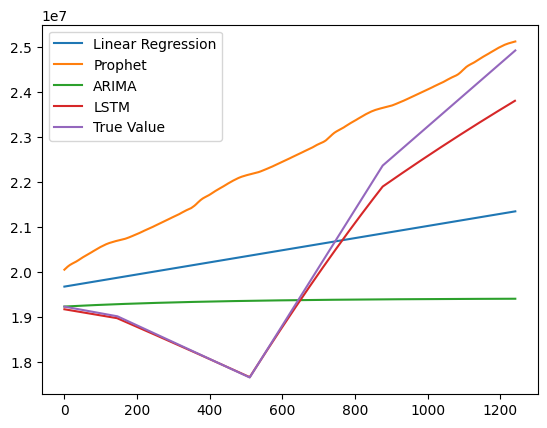

In [110]:
predictions_df.plot()